# **Business Running Case: Evaluating Personal Job Market Prospects in 2024**

In [17]:
import polars as pl
import pandas as pd
import sqlite3
import plotly.express as px
import missingno as msno
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import us 


In [18]:
df = pd.read_csv("lightcast_job_postings.csv")

/var/folders/2c/f5k90sqd3vdfdh_s99mdr09w0000gn/T/ipykernel_63646/3047231268.py:1: DtypeWarning:

Columns (3,6,16,19,22,24,26,28,29,30,32,36,40,42,44,46,48,50,52,54,56,58,60,62,95,97,99,101,103,105,107,109,121) have mixed types. Specify dtype option on import or set low_memory=False.



In [19]:
df.head()

,ID,LAST_UPDATED_DATE,LAST_UPDATED_TIMESTAMP,DUPLICATES,POSTED,EXPIRED,DURATION,SOURCE_TYPES,SOURCES,URL,...,NAICS_2022_2,NAICS_2022_2_NAME,NAICS_2022_3,NAICS_2022_3_NAME,NAICS_2022_4,NAICS_2022_4_NAME,NAICS_2022_5,NAICS_2022_5_NAME,NAICS_2022_6,NAICS_2022_6_NAME
0,1f57d95acf4dc67ed2819eb12f049f6a5c11782c,9/6/24,2024-09-06 20:32:57.352 Z,0,6/2/24,6/8/24,6.0,"[\n ""Company""\n]","[\n ""brassring.com""\n]","[\n ""https://sjobs.brassring.com/TGnewUI/Sear...",...,44,Retail Trade,441.0,Motor Vehicle and Parts Dealers,4413.0,"Automotive Parts, Accessories, and Tire Retailers",44133.0,Automotive Parts and Accessories Retailers,441330.0,Automotive Parts and Accessories Retailers
1,0cb072af26757b6c4ea9464472a50a443af681ac,8/2/24,2024-08-02 17:08:58.838 Z,0,6/2/24,8/1/24,NaN,"[\n ""Job Board""\n]","[\n ""maine.gov""\n]","[\n ""https://joblink.maine.gov/jobs/1085740""\n]",...,56,Administrative and Support and Waste Managemen...,561.0,Administrative and Support Services,5613.0,Employment Services,56132.0,Temporary Help Services,561320.0,Temporary Help Services
2,85318b12b3331fa490d32ad014379df01855c557,9/6/24,2024-09-06 20:32:57.352 Z,1,6/2/24,7/7/24,35.0,"[\n ""Job Board""\n]","[\n ""dejobs.org""\n]","[\n ""https://dejobs.org/dallas-tx/data-analys...",...,52,Finance and Insurance,524.0,Insurance Carriers and Related Activities,5242.0,"Agencies, Brokerages, and Other Insurance Rela...",52429.0,Other Insurance Related Activities,524291.0,Claims Adjusting
3,1b5c3941e54a1889ef4f8ae55b401a550708a310,9/6/24,2024-09-06 20:32:57.352 Z,1,6/2/24,7/20/24,48.0,"[\n ""Job Board""\n]","[\n ""disabledperson.com"",\n ""dejobs.org""\n]","[\n ""https://www.disabledperson.com/jobs/5948...",...,52,Finance and Insurance,522.0,Credit Intermediation and Related Activities,5221.0,Depository Credit Intermediation,52211.0,Commercial Banking,522110.0,Commercial Banking
4,cb5ca25f02bdf25c13edfede7931508bfd9e858f,6/19/24,2024-06-19 07:00:00.000 Z,0,6/2/24,6/17/24,15.0,"[\n ""FreeJobBoard""\n]","[\n ""craigslist.org""\n]","[\n ""https://modesto.craigslist.org/sls/77475...",...,99,Unclassified Industry,999.0,Unclassified Industry,9999.0,Unclassified Industry,99999.0,Unclassified Industry,999999.0,Unclassified Industry


In [20]:
print(df.shape)

(73101, 131)


# **📌 Data Cleaning & Preprocessing**

***Drop Unnecessary Columns***

In [21]:
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
df.drop(columns=columns_to_drop, inplace=True)

*We are removing multiple versions of NAICS/SOC codes because we are going to use the most granular version of those codes available.*

*In this case it is NAICS and SOC codes. Keeping multiple versions would introduce redundancy and potential inconsistencies in our analysis.*

***The following columns are irrelevant or redundant for our analysis and can be dropped to improve efficiency and clarity.***

***ID*** - *unique identifier which is not relevant for analysis*

***URL*** - *job posting urls which is not relevant for analysis*

***ACTIVE_URLS*** - *active urls for job posting which is not relevant for analysis*

***DUPLICATES*** - *whether the job post is duplicate or not*

***LAST_UPDATED_TIMESTAMP*** - *timestamp when the job post was updated*

***NAICS2CS3, NAICS4, NAICS5, NAICS6, NAI***- *less granular versions of NAICS code (we only need NAICS)*

***SOC_2, SOC_3, SOC_5*** - *less granular versions of SOC codes (we only need SOC)*


***Dropping these columns will improve our analysis by:***

*- Reducing the size of the dataset*
*- Removing irrelevant information*
*- Improving the clarity and focus of our analysis by removing unnecessary details.*

***Handling Missing Values***

<Axes: >

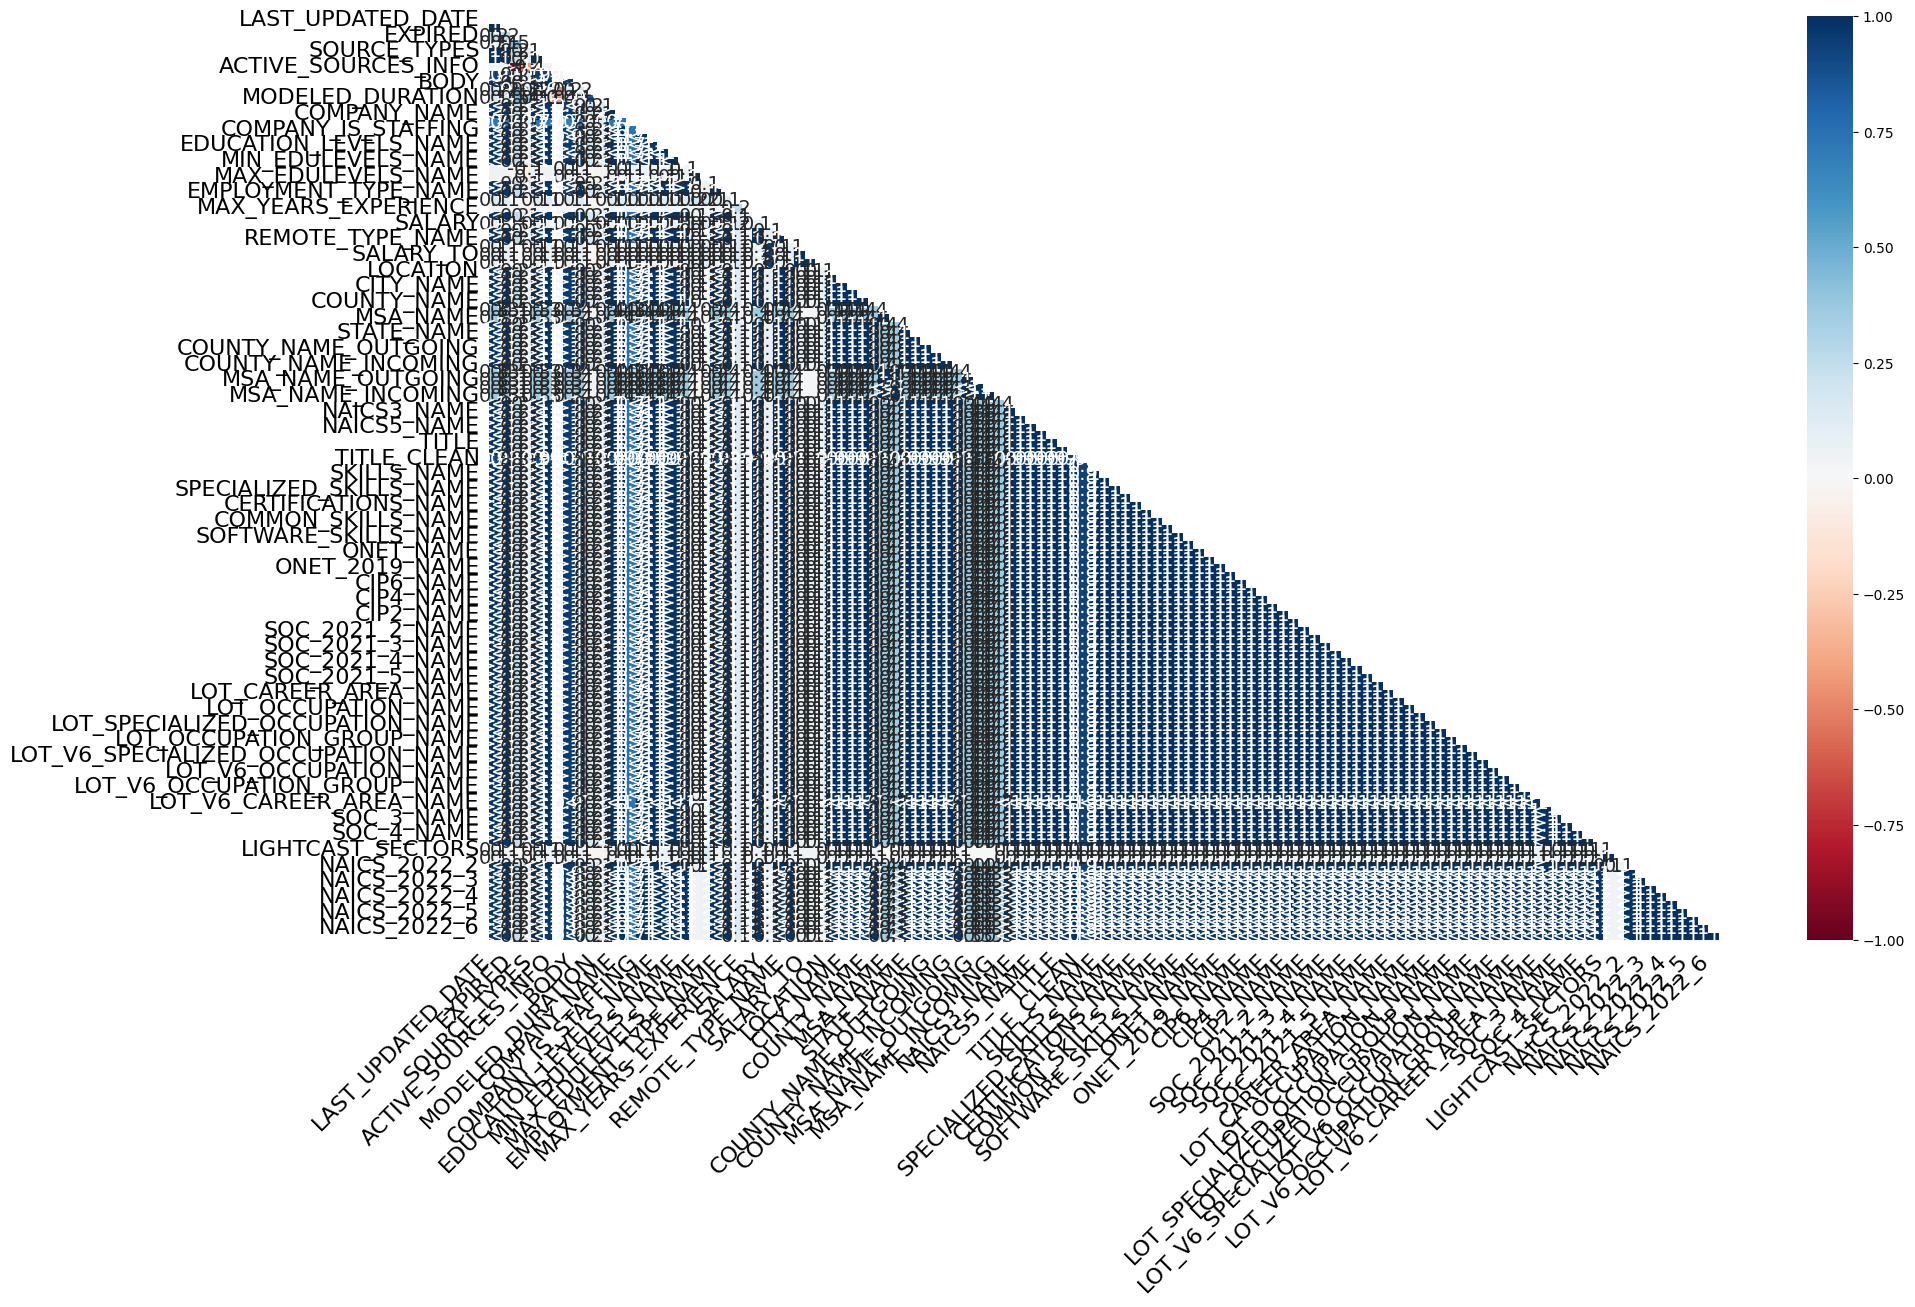

In [22]:
import missingno as msno
# Visualize missing data
msno.heatmap(df)

In [23]:
# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill missing values safely
df["NAICS_2022_6"] = df["NAICS_2022_6"].fillna(df["NAICS_2022_6"].median())
df["NAICS_2022_6_NAME"] = df["NAICS_2022_6_NAME"].fillna("Unknown")


***Remove Duplicates***

*To ensure each job is counted only once, we remove duplicates based on job title, company, location, and posting date.*

In [24]:
df = df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first")

# **📌 Exploratory Data Analysis (EDA)**

***Job Postings by Industry***

In [25]:
top_industries = df["NAICS_2022_6_NAME"].value_counts().nlargest(15)
fig = px.pie(
    names=top_industries.index, 
    values=top_industries.values, 
    title="Top 15 Job Posting Industries"
)
fig

***Monthly Trend of Data-Related Job Postings by Role***

In [26]:
# 1. Filter the main df into df_roles
df_roles = df[df["TITLE_NAME"].str.contains("Data Analysts|Business Intelligence Analysts|Data Analytics Engineers|Data and Reporting Analysts|"
    "Data Governance Analysts|Data Quality Analysts|Data Analytics Analysts|Data Management Analysts|"
    "Data Modelers|Lead Data Analysts|Research Data Analysts|IT Data Analysts|Data Analytics Manager|"
    "Lead Business Intelligence Analysts|Data Science Analysts|Data Analytics Leads|"
    "Business Intelligence Data Analysts|Data Operations Analysts|Health Data Analysts|"
    "Data analytics consultants|Enterprise Data Analysts", case=False, na=False)]

# 1. Make a copy to avoid SettingWithCopyWarning
df_roles = df_roles.copy()

# 2. Convert POSTED to datetime (if not already)
df_roles["POSTED"] = pd.to_datetime(df_roles["POSTED"])

# 3. Create a monthly column as a Timestamp
df_roles["month"] = df_roles["POSTED"].dt.to_period("M").dt.to_timestamp()

# 4. Group by month and role
monthly_counts = df_roles.groupby(["month", "TITLE_NAME"]).size().reset_index(name="count")

fig = px.area(
    monthly_counts,
    x="month",
    y="count",
    color="TITLE_NAME",
    title="Monthly Trend of Data-Related Job Postings by Role (Stacked Area)"
)
fig.show()

/var/folders/2c/f5k90sqd3vdfdh_s99mdr09w0000gn/T/ipykernel_63646/218932778.py:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



***Remote vs. On-Site Jobs ( Data Roles )***

In [27]:
fig = px.pie(df_roles, names="REMOTE_TYPE_NAME", title="Remote vs. On-Site Jobs")
fig.show()

***Data-Related Job Postings Across the USA***

In [28]:
# 🔹 Step 1: Filter for Data-Related Roles

# 🔹 Step 2: Aggregate Job Counts by State
job_counts = data_roles["STATE_NAME"].value_counts().reset_index()
job_counts.columns = ["state", "job_postings"]

# 🔹 Step 3: Convert Full State Names to Abbreviations
job_counts["state"] = job_counts["state"].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x)

# 🔹 Step 4: Create Choropleth Map
fig = px.choropleth(
    job_counts,
    locations="state",
    locationmode="USA-states",  # Correct location mode for US states
    color="job_postings",  # Color by job count
    hover_name="state",
    color_continuous_scale="Viridis",  # High-contrast color scheme
    title="Data-Related Job Postings Across the USA",
    scope="usa"  # Focus on the USA
)

fig.show()

***Industries related to data roles***

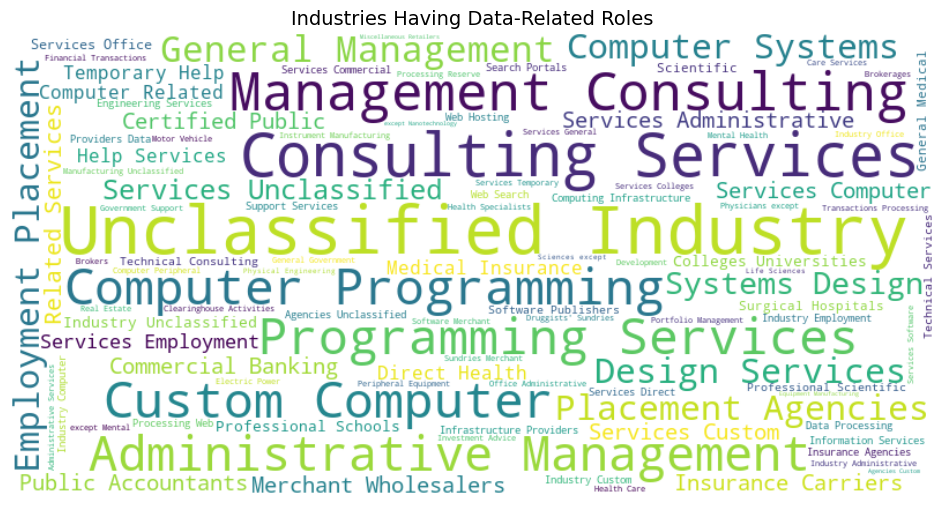

In [29]:
# Filter industries related to data roles
data_roles = df[df["NAICS_2022_6_NAME"].str.contains(
    "|Data Analysts|Business Intelligence Analysts|Data Analytics Engineers|Data and Reporting Analysts|Data Governance Analysts|Data Quality Analysts|Data Analytics Analysts|Data Management Analysts|Data Modelers|Lead Data Analysts|Research Data Analysts|IT Data Analysts|Data Analytics Manager|Lead Business Intelligence Analysts|Data Science Analysts|Data Analytics Leads|Business Intelligence Data Analysts|Data Operations Analysts|Health Data Analysts|Data analytics consultants|Enterprise Data Analysts|", 
    case=False, na=False
)]

# Get industries associated with these roles
industry_text = " ".join(data_roles["NAICS_2022_6_NAME"].dropna())

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", 
    colormap="viridis", max_words=100
).generate(industry_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Industries Having Data-Related Roles", fontsize=14)
plt.show()